# Text Classification by author 

In [85]:
import numpy as np
import pandas as pd
import nltk
import os
from pathlib import Path
from nltk.corpus import PlaintextCorpusReader
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import scipy
from sklearn.decomposition import TruncatedSVD, PCA


nltk.download('wordnet')

%matplotlib inline 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Loren\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Books
* The Secret Adversary - Agatha Christie
* Walden, and On The Duty Of Civil Disobedience - Henry David Thoreau
* Treasure Island - Robert Louis Stevenson
* The Hound of the Baskervilles - Arthur Conan Doyle
* The Picture of Dorian Gray - Oscar Wilde
* The Narrative of the Life of Frederick Douglass, An American Slave - Frederick Douglass
* Anne of Green Gables - Lucy Maud Montgomery
* The TIme Machine - H. G. Wells
* A Tale of Two Cities - Charles Dickens
* The Wonderful Wizard of Oz - L. Frank Baum

### Gather and organize data

In [2]:
files = os.listdir('texts')

In [3]:
corpus_root = r'..\unit_4\texts'
texts = PlaintextCorpusReader(corpus_root, '.*')
texts.fileids()

['A Tale of Two Cities-Dickens.txt',
 'Anne of Green Gables-Montgomery.txt',
 'The Hound of the Baskervilles-Doyle.txt',
 'The Narrative of the Life of Frederick Douglass-Douglass.txt',
 'The Picture of Dorian Gray-Wilde.txt',
 'The Time Machine-Wells.txt',
 'The Wonderful Wizard of Oz-Baum.txt',
 'Treasure Island-Stevenson.txt',
 'Walden-Thoreau.txt',
 'the_secret_adversary-Christie.txt']

In [4]:
books = []
for file in files:
    author = re.search(r'(?<=-)\w+', file).group()
    books.append([file, author])

In [5]:
# Create list of sentences with author label
sents_list = []
# limit to 1900 sentences for each book
for book in books:
    sents = texts.sents(book[0])[100:2000]
    joined_sents = [(' '.join(sent), book[1]) for sent in sents]
    
    for i in joined_sents:
        sents_list.append(i)
        

In [36]:
# Make dataframe and rename columns
df = pd.DataFrame(sents_list)
df.columns = ['sentence', 'author']

In [37]:
df.shape

(19000, 2)

In [38]:
df.head()

,sentence,author
0,“ Never you mind what it is !” the guard retor...,Dickens
1,“ What are you ?”,Dickens
2,“ _Is_ that the Dover mail ?”,Dickens
3,“ Why do you want to know ?”,Dickens
4,"“ I want a passenger , if it is .”",Dickens


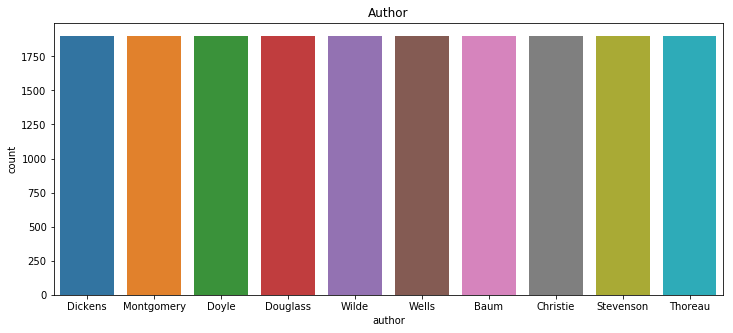

In [39]:
plt.figure(figsize=(12,5))
sns.countplot(x="author", data=df);
plt.title('Author')


plt.show()

### Text Cleaning

In [40]:
#Create cleaning function
def text_cleaner(text):
    #make lowercase
    text = text.lower()
    #remove line breaks
    text = re.sub(r'<br \/>','',text)
    #remove punctuation
    text = re.sub(r'[^\w\s]','',text)
    return text
    

In [41]:
df['sentence'] = df['sentence'].apply(text_cleaner)

In [42]:
for i in np.arange(1, 19000, 2000):
    print(df['sentence'][i])

 what are you 
i wouldn  t be a bit afraid  and it would be lovely to sleep in a wild cherry  tree all white with bloom in the moonshine  don  t you think 
he chanced to be at his hall door 
in either case  he was severely whipped by the chief gardener 
courage has gone out of our race 
and the children seemed to my eyes to be but the miniatures of their parents 
asked the scarecrow 
 there  said tuppence at last 
dance  said the squire   you are a very noble fellow 
i was seated by the shore of a small pond  about a mile and a half south of the village of concord and somewhat higher than it  in the midst of an extensive wood between that town and lincoln  and about two miles south of that our only field known to fame  concord battle ground  but i was so low in the woods that the opposite shore  half a mile off  like the rest  covered with wood  was my most distant horizon 


In [35]:
sw = stopwords.words('English')

# Feature Generation using TF-IDF

In [44]:
tfidf = TfidfVectorizer(ngram_range=(1, 2),
                        max_features=5000,
                       strip_accents='ascii',
                       analyzer='word',
                       stop_words=sw,
                       max_df=0.7)

In [45]:
tfidf_features = tfidf.fit_transform(df['sentence'])
features = tfidf_features.toarray()
feature_names = tfidf.get_feature_names()
features_df = pd.DataFrame(features, columns=feature_names)

In [63]:
features_df.head()

,00,10,12,14,15,17,20,25,40,_do_,...,yonder,york,young,young adventurers,young jerry,young lady,young man,young men,younger,youth
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
# Add a feature for the length of each sentense

def length(text):
    return len(text)

features_df['sen_length'] = df['sentence'].apply(length)

# Modeling 

In [95]:
# Normalize for clustering
features_norm = normalize(features_df)
Y = pd.Categorical(df['author']).codes
# Create train and test groups
X_train, X_test, Y_train, Y_test = train_test_split(features_norm, Y, test_size=.3, random_state=0)

#### Lets use feature reduction to visualize the actual labels.

In [77]:
SVD = TruncatedSVD(2)
X_train_svd = SVD.fit_transform(X_train)

In [96]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

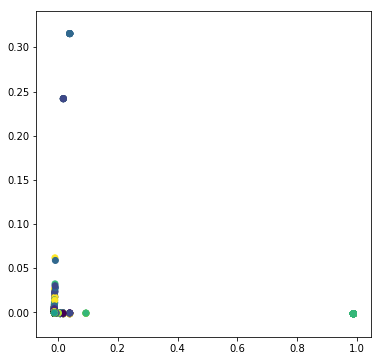

In [98]:
plt.figure(figsize=(6,6))

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=Y_train)

plt.show()

# K-Means

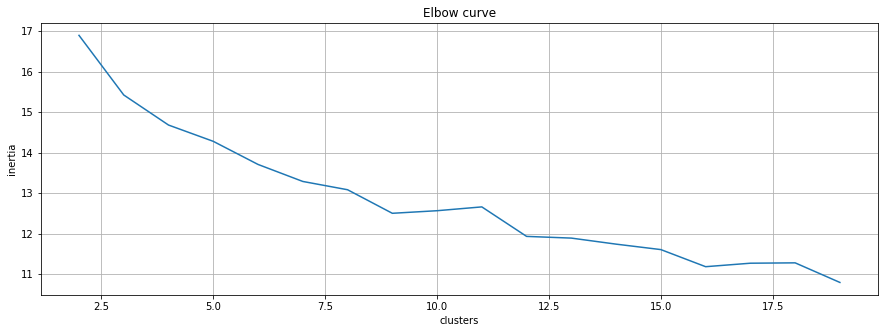

In [99]:
distortion = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    distortion.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distortion)
plt.grid(True)
plt.title('Elbow curve')
plt.xlabel("clusters")
plt.ylabel('inertia')
plt.show()

In [100]:
#Get predicted clusters
y_pred = KMeans(n_clusters=10, random_state=0).fit_predict(X_train)



In [101]:
pd.crosstab(Y_train, y_pred)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,0,0,1,0,0,2,0,0,1327,0
1,0,0,0,2,0,1,3,0,1310,6
2,0,0,0,1,0,2,3,2,1354,8
3,0,1,0,0,4,0,10,0,1307,1
4,2,1,0,0,0,0,0,0,1329,2
5,0,0,0,0,0,1,1,0,1346,1
6,0,147,2,0,0,0,1,0,1140,0
7,0,1,0,0,0,0,0,0,1340,0
8,0,0,0,0,0,0,0,1,1326,0
